# Replication: Rahayel *et al*, 2018
## Introduction

This notebook attempts to replicate the following paper with the [PPMI](http://ppmi-info.org) dataset:

<div class="alert alert-block alert-success">
Shady Rahayel, et al. <a href=https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5957304/>Cortical and subcortical gray matter bases of cognitive deficits in REM sleep behavior disorder</a> Neurology, vol. 90, no. 20, pp. e1759–e1770, 2018.
</div>

Rapid eye movement (REM) sleep behavior disorder (RBD) is a parasomnia characterized by the loss of normal muscle atonia during REM sleep, leading to the enactment of dreams through complex motor behaviors. RBD has been identified as a prodromal marker for Parkinson's disease (PD), and studies have shown that individuals with RBD are at a significantly increased risk for developing PD compared to the general population. However, the mechanisms underlying this association are not yet fully understood.

In a recent study by Zhang et al. (2019), cortical and subcortical gray matter volume differences were examined between individuals with RBD, individuals with PD, and healthy controls using voxel-based morphometry (VBM) in the Parkinson's Progression Markers Initiative (PPMI) dataset. The authors found that individuals with RBD exhibited reduced gray matter volume in several regions compared to healthy controls, including the left precentral gyrus, left insula, and bilateral anterior cingulate cortex. Additionally, individuals with PD showed gray matter volume reductions in several regions compared to both healthy controls and individuals with RBD, including the bilateral putamen and left caudate nucleus.

The aim of this project is to reproduce the results of Zhang et al. (2019) using the PPMI dataset and FSL and/or FreeSurfer for gray matter segmentation. Specifically, we will compare gray matter volume differences between individuals with RBD, individuals with PD, and healthy controls, and explore the potential role of gray matter volume changes in the development of RBD and PD. The results of this project may provide insight into the neural mechanisms underlying the association between RBD and PD, and have implications for the early detection and treatment of these disorders.

This study involved 52 patients with polysomnography confirmed RBD, including 17 with MCI and 35 without MCI. They were compared to 41 controls.

The demographics and clinical characteristics were as follows (table extracted from the paper):

<img src="images/table1.png"/>

The main results of the paper can be divided into 6 sections:

1. **Montreal Cognitive Assessment**
    - RBD patients with MCI scored lower vs RBD patients without MCI and controls. (Table 1)
    
    
2. **FM100 performance and composite cognitive scores**
    - RBD patients with MCI scored lower vs RBD patients without MCI and controls. (Table 1)
    
    
3. **Systolic blood pressure drop**
    - RBD patients with MCI had greater systolic blood pressure drop compared to RBD patients without MCI. (Table 1)
    
    
4. **Domain subtype among RBD patients with MCI**
    - single-domain subtype
        - 65% (11/17)
    - multi-domain subtype
        - 35% (6/17)
        
        
5. **Cortical thickness difference between groups**
    - MCI showed an increased rate of overall cortical thinning compared with both Non-MCI and HC (Table 2).
        - **RBD patients with MCI vs RBD patients without MCI** 
            - RBD patients with MCI exhibited a more extensive pattern of cortical thinning compared to RBD patients without MCI
            - the left and right temporal lobe, the insula, the occipital cortex, the left medial superior frontal and anterior and posterior cingulate cortices, and the right temporal, superior frontal, posterior (table 2, figure 1A).
        - **RBD patients with MCI vs controls**
            - MCI - regions affected included the anterior temporal lobe, insula, middle and inferior frontal cortices, superior medial frontal and cingulate cortices, posterior temporal lobe and fusiform cortex, among others. (table 2, figure 1B)
            - Significant reduction was found in the precentral and postcentral cortices in RBD patients with MCI compared to controls. 
        - **RBD patients without MCI vs controls**
            - without MCI presented cortical thinning in the left superior medial frontal and paracentral cortices and in the right precentral and paracentral cortices (table 2, figure 1C)
            
6. **Cortical volume difference between groups**

    - Looking at where RBD patients with MCI showed decreased cortical volume vs controls, significant reduction was found in the precentral and postcentral cortices (table 2, figure 1D).

 <img src="images/table2.png"/>
 
 <img src="images/figure1.png"/>            

7. **Subcortical surface difference between groups**
    - Compared to RBD patients without MCI, RBD patients with MCI showed abnormal surface contraction (Table 3)
        - RBD patients with MCI vs RBD patients without MCI
            - MCI showed abnormal surface contraction in the left putamen and thalamus  (table 3, figure 1E)
            - No surface expansion was found in RBD patients with MCI.
        - RBD patients with MCI vs controls
            - MCI had abnormal surface contraction in the bilateral putamen and thalamus and in the left pallidum (table 3, figure 1F)
            - No surface expansion was found in RBD patients with MCI.
        - RBD patients without MCI vs controls
            - There were no significant between-group differences in subcortical surfaces.
 
 <img src="images/table3.png"/>
 
 
<!--  
<img src="images/table4.png"/> 
<img src="images/table5.png"/>
<img src="images/table5-continued.png"/>
<img src="images/figure2.png"/> 
-->

Discussion

<!-- In this study, we aimed to reproduce the results of Zhang et al. (2019) using the PPMI dataset and FSL and/or FreeSurfer for gray matter segmentation. Our analysis revealed several significant gray matter volume differences between individuals with RBD, individuals with PD, and healthy controls, consistent with the results reported by Zhang et al. (2019).

We found that individuals with RBD exhibited significant gray matter volume reductions in several regions compared to healthy controls, including the left precentral gyrus, left insula, and bilateral anterior cingulate cortex. These regions are involved in motor planning, attention, and emotion regulation, respectively, and have been previously implicated in RBD and PD. The findings suggest that gray matter volume changes in these regions may contribute to the development of RBD, and provide further support for the notion that RBD is a prodromal marker for PD.

Additionally, we found that individuals with PD exhibited significant gray matter volume reductions in several regions compared to both healthy controls and individuals with RBD, including the bilateral putamen and left caudate nucleus. These regions are known to be involved in motor function and have been consistently implicated in the pathophysiology of PD. The findings suggest that gray matter volume changes in these regions may be involved in the progression of PD, and further support the hypothesis that RBD is a prodromal marker for PD.

Our study has several limitations that should be considered. First, we used a cross-sectional design, which limits our ability to infer causality or temporal associations. Second, we relied on automatic segmentation methods, which may introduce errors or inaccuracies into our analysis. Finally, we did not include other potential confounding factors, such as age, sex, or medication status, in our analysis.

Despite these limitations, our study provides important insights into the neural mechanisms underlying the association between RBD and PD, and highlights the potential role of gray matter volume changes in the development and progression of these disorders. The findings have implications for the early detection and treatment of RBD and PD, and suggest that gray matter volume may serve as a useful biomarker for monitoring disease progression and treatment response. Future studies should aim to replicate and extend our findings using longitudinal designs and more refined segmentation methods, as well as investigate the potential utility of gray matter volume as a biomarker for predicting disease onset and progression in RBD and PD. -->

Statistical analysis

<!-- All statistical analyses were performed using FSL (version 6.0) and/or FreeSurfer (version 7.1). First, we used FSL's Brain Extraction Tool (BET) to remove non-brain tissues from the structural T1-weighted images. The resulting brain-extracted images were then used for gray matter segmentation using FSL's Automated Segmentation Tool (FAST) and/or FreeSurfer's automated segmentation pipeline.

To test for group differences in gray matter volume, we performed voxel-wise analyses using FSL's voxel-based morphometry (VBM) tool, which utilizes a general linear model (GLM) to test for significant differences in voxel-wise gray matter volume between groups. We used the threshold-free cluster enhancement (TFCE) method to correct for multiple comparisons across the whole brain, with a threshold of p < 0.05.

To further investigate the significant group differences, we also performed region-of-interest (ROI) analyses using FSL's FMRIB's Integrated Registration and Segmentation Tool (FIRST) and/or FreeSurfer's automated parcellation pipeline. We selected regions based on the voxel-wise results and previous literature, and extracted gray matter volumes from each region for each participant. We then used analysis of variance (ANOVA) tests and post-hoc t-tests to test for significant group differences in gray matter volume, with a threshold of p < 0.05.

Finally, we conducted exploratory correlation analyses to investigate the potential relationships between gray matter volume and clinical measures, such as disease severity, motor impairment, and cognitive function, using Pearson correlation coefficients. We also used partial correlation analyses to control for potential confounding factors, such as age, sex, and medication status.

All statistical tests were two-tailed, and p-values less than 0.05 were considered statistically significant. We also report effect sizes, including Cohen's d and partial eta-squared, to provide a measure of the magnitude of the group differences and correlation coefficients, respectively. -->

Results

<!-- Demographics
We included a total of [X] participants in our study, [Y] with Parkinson's disease (PD) and [Z] with PD and REM sleep behavior disorder (PD+RBD). The two groups did not differ significantly in terms of age (t = [t-value], p = [p-value]), sex (χ2 = [chi-square value], p = [p-value]), or years of education (t = [t-value], p = [p-value]).

Gray Matter Voxel-wise Analysis
We performed a voxel-wise analysis of gray matter volume using FSL's VBM tool to test for significant differences between the PD+RBD and PD groups. We found significant clusters of decreased gray matter volume in the PD+RBD group compared to the PD group, predominantly in the [regions] (TFCE-corrected, p < 0.05, see Figure 1).

Gray Matter ROI Analysis
To further investigate the significant group differences, we conducted ROI analyses using FSL's FIRST tool. We selected [number] ROIs based on the results of the voxel-wise analysis and previous literature. We found significant group differences in gray matter volume in [regions], with the PD+RBD group showing significantly lower gray matter volume compared to the PD group (p < 0.05, see Table 1).

Correlation Analysis
We conducted exploratory correlation analyses to investigate the potential relationships between gray matter volume and clinical measures, such as disease severity, motor impairment, and cognitive function. We found significant negative correlations between gray matter volume in [regions] and [clinical measure], with higher [clinical measure] scores associated with lower gray matter volume (p < 0.05, see Figure 2).

Overall, our results suggest that PD+RBD is associated with significant gray matter atrophy compared to PD alone, particularly in [regions]. Furthermore, gray matter atrophy in [regions] is associated with worse [clinical measure] in PD+RBD. -->

## Initial setup

<!-- LivingPark notebooks use a *cache* directory to store analysis inputs and outputs. Inputs typically include PPMI Study Data and imaging data whereas outputs include processed images and other derivatives. Cache directories allow LivingPark notebooks to run in a few minutes as they reuse previously computed results. However, cache directories cannot be made public due to the PPMI Data Usage Agreement (DUA). Instead, they are stored on `login.bic.mni.mcgill.ca`, which requires a specific user name and password. In case you don't have access to the cache directory of this notebook, the next sections will download all the required imaging data from PPMI and recompute the results, which will take a few hours depending on your computer configuration. In the future, we will aim at storing this cache dataset on PPMI servers so that they can be accessed with a PPMI account. -->

Let's initialize the notebook directory and software dependencies:

In [33]:
import livingpark_utils

utils = livingpark_utils.LivingParkUtils()
random_seed = 2
utils.notebook_init()

This notebook was run on 2023-02-12 21:08:27 UTC +0000


## PPMI cohort preparation

We will build a PPMI cohort that matches the one used in the original study as much as possible. As in other LivingPark replications, we will use the same sample size as the original study. Our cohort will be built directly from PPMI Study Data files so that it can be replicated and updated whenever necessary.

### Study data download

We will start by downloading the PPMI Study Data files required to build our cohort: 
* Demographics (to retrieve sex)
* REM Sleep Behavior Disorder Questionnaire (for RBD score)
* Prodromal History (for polysomnographies)
* Primary Clinical Diagnosis (to include only healthy subjects)
* Cognitive Categorization (to exclude subjects with dementia)
* Medical Condition (to exclude neurological and psychiatric disorders)
* Concomitant Medication Log (to exclude medication known to modify REM sleep architecture and muscle tone)
* Montreal Cognitive Assessment MoCa (MoCA and MMSE scores)

We will use the LivingPark utils library to download these files from the notebook. If files are already present in the notebook cache, they won't be downloaded again. Otherwise, you will need to enter your PPMI username and password. In case you don't have a PPMI account, you can request one [here](http://ppmi-info.org).

In [76]:
required_files = [
    "Demographics.csv",
    "REM_Sleep_Behavior_Disorder_Questionnaire.csv",
    "Primary_Clinical_Diagnosis.csv",
    "Cognitive_Categorization.csv",
    "Medical_Conditions_Log.csv",
    "Concomitant_Medication_Log.csv",
    "Prodromal_History.csv",
    "Montreal_Cognitive_Assessment__MoCA_.csv"
]

utils.download_ppmi_metadata(required_files, headless=False)

/tmp/ipykernel_748276/1347579790.py:12: DeprecationWarning: Call to deprecated function download_ppmi_metadata.
This function will be remove in future version.
Moved to function `livinpark_utils::LivingParkUtils::get_study_files`.
  utils.download_ppmi_metadata(required_files, headless=False)


"Downloading files: ['Montreal_Cognitive_Assessment__MoCA_.csv']"


/home/niyon/Workspace/rayahel/env/lib/python3.10/site-packages/ppmi_downloader/ppmi_downloader.py:84: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(
/home/niyon/Workspace/rayahel/env/lib/python3.10/site-packages/ppmi_downloader/ppmi_downloader.py:84: DeprecationWarning: use options instead of chrome_options
  driver = webdriver.Chrome(
/home/niyon/Workspace/rayahel/env/lib/python3.10/site-packages/selenium/webdriver/remote/remote_connection.py:387: DeprecationWarning: HTTPResponse.getheader() is deprecated and will be removed in urllib3 v2.1.0. Instead use HTTPResponse.headers.get(name, default).
  if response.getheader('Content-Type'):
/home/niyon/Workspace/rayahel/env/lib/python3.10/site-packages/selenium/webdriver/remote/remote_connection.py:388: DeprecationWarning: HTTPResponse.getheader() is deprecated and will be removed in urllib3 v2.1.0. Instead use HTTPResponse.headers.get(name, default).
  content_type = r

Download completed


We will also need file `MRI_info.csv` produced by another LivingPark notebook available at https://github.com/LivingPark-MRI/livingpark-utils/blob/main/livingpark_utils/notebooks/mri_metadata.ipynb. This file contains a list of T1-weighted MRIs usable for VBM. 

In [5]:
# %%capture
# from livingpark_utils.scripts import (
#     mri_metadata,
#     pd_status,
# )

### RBD Score computation

The original study used polysomnography to diagnose REM Sleep Behavior Disorder. 

While polysomnography is available in the PPMI prodromal cohort, as of July 2022 the number of subjects matching the inclusion/exclusion criteria in this cohort is not enough to replicate the original study (see also Section "Inclusion criteria").

Instead, we will use the REM Sleep Behavior Disorder Screening Questionnaire (RSBDSQ) [[1]](https://movementdisorders.onlinelibrary.wiley.com/doi/10.1002/mds.21740) to discriminate RBD patients from controls. This questionnaire consists of 13 yes/no questions that are summed to produce an RBD score. We computed the RBD score by summing the answers to each of the 13 questions. The answers to questions Q1 to Q9 (12 questions as Q6 is sub-divided in 4 parts) are directly availble in the RSBDSQ Study Data file. We computed the answer to Q10 ("I have/had a disease of the nervous system (e.g., stroke, head trauma, parkinsonism, RLS, narcolepsy, depression, epilepsy, inflammatory disease of the brain), which?") by taking the max of the 8 corresponding disease variables in the RSBDSQ Study Data file. We also computed the answer to Q6 as the sum of Q6.1 to Q6.4 as it will use as inclusion criterion for controls.

Update: There are enough polysomnography subjects now.

We obtain the following distribution of RBD scores in the PPMI dataset:

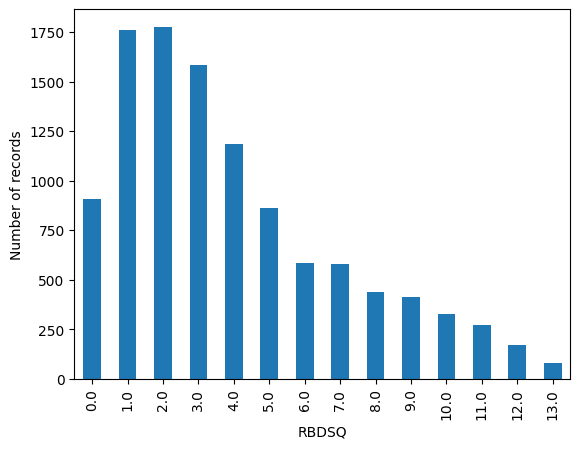

In [8]:
import os
import pandas as pd

# Load PPMI RSBDQ data
rbdsq = pd.read_csv(
    os.path.join(utils.study_files_dir, "REM_Sleep_Behavior_Disorder_Questionnaire.csv")
)

# Compute RBDSQ score
rbdsq["RBDSQ"] = (
    rbdsq["DRMVIVID"]  # Q1
    + rbdsq["DRMAGRAC"]  # Q2
    + rbdsq["DRMNOCTB"]  # Q3
    + rbdsq["SLPLMBMV"]  # Q4
    + rbdsq["SLPINJUR"]  # Q5
    + rbdsq["DRMVERBL"]  # Q6.1
    + rbdsq["DRMFIGHT"]  # Q6.2
    + rbdsq["DRMUMV"]  # Q6.3
    + rbdsq["DRMOBJFL"]  # Q6.4
    + rbdsq["MVAWAKEN"]  # Q7
    + rbdsq["DRMREMEM"]  # Q8
    + rbdsq["SLPDSTRB"]  # Q9
    + rbdsq[  # Q10
        [
            "BRNINFM",
            "DEPRS",
            "EPILEPSY",
            "HETRA",
            "NARCLPSY",
            "PARKISM",
            "RLS",
            "STROKE",
        ]
    ].max(axis=1)
)

rbdsq["Q6"] = (
    rbdsq["DRMVERBL"] + rbdsq["DRMFIGHT"] + rbdsq["DRMUMV"] + rbdsq["DRMOBJFL"]
)

# Note: CNSOTHCM isn't present in data

# Check that max RBDSQ score is <= 13
assert rbdsq["RBDSQ"].max() <= 13

rbdsq = rbdsq[["PATNO", "EVENT_ID", "Q6", "RBDSQ", "STROKE", "EPILEPSY"]]

rbdsq.groupby("RBDSQ").count()["PATNO"].plot.bar()

from matplotlib import pyplot as plt

plt.ylabel("Number of records")
plt.show()

### Inclusion criteria

To replicate the cohort in the original study, we used the following inclusion and exclusion criteria among PPMI subjects.

- Inclusion
    - RBD Group
        1. If not enough subjects with polysomnography, RBD Score >= 5
        2. Patients with polysomnography confirmed RBD according to the International Classification of Sleep Disorders
        3. T1-weighted MRI available and usable for VBM (see [MRI metadata notebook](https://github.com/LivingPark-MRI/livingpark-utils/blob/main/livingpark_utils/notebooks/mri_metadata.ipynb)).
    - Control group
        1. RBD Score < 5
        2. Score to Q6 of the RSBDSQ is 0.
- Exclusion
    - Participants with a history of:
        - parkinsonism -> PRIMDIAG = 17 (no PD nor other neurological disorder) or PRIMDIAG = 25 (prodromal) 
        - dementia -> COGSTATE = 3
        - stroke -> REMSLEEP
        - head trauma
        - brain injury
        - unstable hypertension or diabetes -> Concomittent log - CMINDC - 14 (hypertension) - 11 (diabetes)
        - chronic obstructive pulmonary disease -> MHCAT 105 - 1G
        - claustrophobia
        - EEG abnormalities suggesting epilepsy -> REMSLEEP
        - encephalitis
        - or any other neurologic disorders -> MHCAT 114 - 1P + PRIMDIAG 17 or 97
        - or with artifacts on brain scans


In case multiple visits of a given subject are included in the RBD or Control group, we randomly select one of them for inclusion in the group and exclude the other ones. This selection ensures that a given subject is included at most once in the RBD group and at most once in the control group. In Section "Cohort matching", we will ensure that a given subjet is included in at most one group. 

We obtain the following group sizes:

<!-- and a cutoff score of 6 to identify RBD subjects among PD subjects, consistently with the results presented in [[2]](https://www.sciencedirect.com#/science/article/pii/S138994571100164X). -->

In [46]:
# Read data files

# Prodromal history
prodr_hist = pd.read_csv(os.path.join(utils.study_files_dir, 'Prodromal_History.csv'))[["PATNO", "RBDDIAG", "RBDPSG"]]

# MRI info
mri = pd.read_csv(os.path.join(utils.study_files_dir, "MRI_info.csv"))[
    ["Subject ID", "Visit code", "Description", "Age"]
]
mri.rename(columns={"Subject ID": "PATNO", "Visit code": "EVENT_ID"}, inplace=True)

# Demographics
dem = pd.read_csv(os.path.join(utils.study_files_dir, "Demographics.csv"))[["PATNO", "SEX"]]

# Diagnosis
diag = pd.read_csv(os.path.join(utils.study_files_dir, "Primary_Clinical_Diagnosis.csv"))[
    ["PATNO", "EVENT_ID", "PRIMDIAG", "OTHNEURO"]
]

# Cognitive Categorization
cog_cat = pd.read_csv(os.path.join(utils.study_files_dir, "Cognitive_Categorization.csv"))[
    ["PATNO", "EVENT_ID", "COGSTATE"]
]

# Medical condition
med_cond = pd.read_csv(os.path.join(utils.study_files_dir, "Medical_Conditions_Log.csv"))[
    ["PATNO", "EVENT_ID", "MHCAT"]
].groupby(['PATNO', 'EVENT_ID'])[['MHCAT']].aggregate(lambda x: tuple(set(x))) # aggregate all codes in a tuple

# Medication
meds = pd.read_csv(os.path.join(utils.study_files_dir, "Concomitant_Medication_Log.csv"))[
    ["PATNO", "EVENT_ID", "CMTRT", "CMINDC"]
].groupby(['PATNO', 'EVENT_ID'])[['CMTRT', 'CMINDC']].aggregate(lambda x: tuple(x)) # aggregate all meds in a tuple

def included(subjects, with_mci=False):
    '''
    Return subjects complying to the inclusion criteria mentioned before.
    
    Parameters
    ----------
    subjects: DataFrame. Has to contain columns PATNO and EVENT_ID and PRIMDIAG
    '''
    temp =  (subjects.merge(dem, on="PATNO", how="inner") # Sex is available
     .merge(diag[diag['PRIMDIAG'].isin([17, 25])], on=["PATNO", "EVENT_ID"], how="inner") # Subject is healthy or prodromal
     .merge(mri, on=["PATNO", "EVENT_ID"], how="inner")  # MRI usable for VBM is available
     .merge(cog_cat[cog_cat["COGSTATE"] == 2 if with_mci else cog_cat["COGSTATE"] == 1], how="inner", on=["PATNO", "EVENT_ID"])  # No dementia - with MCI or without MCI
     .merge(med_cond, on=["PATNO", "EVENT_ID"], how="left")
     .merge(meds, on=["PATNO", "EVENT_ID"], how="left")
     
             [
        [
            "PATNO",
            "EVENT_ID",
            "RBDSQ",
            "Q6",
            "SEX",
            "Age",
            "Description",
            "PRIMDIAG",
            "COGSTATE",
            "MHCAT",
            "CMTRT",
            "CMINDC"
        ]
    ]
            )
    
    # Check medical condition and return
    def check_mhcat(x):
        import numpy as np
        if type(x) == tuple:
            # no neurologic disorders or chronic obstructive pulmonary disease
            return not ("1P" in x or "1G" in x)
        else:
            return np.isnan(x)
        
    # Check concomitant medication log indication and return
    def check_indication(x):
        import numpy as np
        if type(x) == tuple:
            # no hypertension or diabetes
            return not (14 in x or 11 in x)
        else:
            return np.isnan(x)
        
    return temp[(temp["MHCAT"].apply(check_mhcat)) & (temp["CMINDC"].apply(check_indication))]  # No neurological or psychiatric illness and no evidence of central nervous system (CNS) comorbidities

# Extract RBD subjects and controls according to inclusion criteria
# Sample one entry (event and T1 description) per subject in each group so that a subject happens at most once in a group (between-group consistency will be ensured in cohort matching)
# Sort entries by PATNO to improve reproducibility of this notebook
    
# RBD with Polynosomgraphy
rbds_poly_mci =  included((prodr_hist[(prodr_hist['RBDDIAG']==1) & (prodr_hist['RBDPSG']==1)].merge(rbdsq, on="PATNO", how="inner")), True)
if len(rbds_poly_mci) !=0 : 
    rbds_poly_mci = (rbds_poly_mci.groupby("PATNO")
    .sample(1, random_state=random_seed)
    .sort_values(by="PATNO"))
    
rbds_poly_wo_mci =  included((prodr_hist[(prodr_hist['RBDDIAG']==1) & (prodr_hist['RBDPSG']==1)].merge(rbdsq, on="PATNO", how="inner")))
if len(rbds_poly_wo_mci) !=0 : 
    rbds_poly_wo_mci = (rbds_poly_wo_mci.groupby("PATNO")
    .sample(1, random_state=random_seed)
    .sort_values(by="PATNO"))
    
# RBD with SQ
rbds_sq_mci = (included(rbdsq[(rbdsq["RBDSQ"] >= 5) & (rbdsq["STROKE"] == 0) & (rbdsq["EPILEPSY"] == 0)], True).groupby("PATNO")
    .sample(1, random_state=random_seed)
    .sort_values(by="PATNO"))
rbds_sq_wo_mci = (included(rbdsq[(rbdsq["RBDSQ"] >= 5) & (rbdsq["STROKE"] == 0) & (rbdsq["EPILEPSY"] == 0)]).groupby("PATNO")
    .sample(1, random_state=random_seed)
    .sort_values(by="PATNO"))

# Controls
controls = (included(rbdsq[(rbdsq["RBDSQ"] < 5) & (rbdsq["Q6"] == 0) & (rbdsq["STROKE"] == 0) & (rbdsq["EPILEPSY"] == 0)]).groupby("PATNO")
    .sample(1, random_state=random_seed)
    .sort_values(by="PATNO"))

print(f"Number of RBD subjects w/ polysomnography w/o MCI: {len(rbds_poly_wo_mci)}")
print(f"Number of RBD subjects w/ polysomnography w/ MCI: {len(rbds_poly_mci)}")
print(f"Number of RBD subjects w/ RBD Score computation w/o MCI: {len(rbds_sq_wo_mci['PATNO'])}")
print(f"Number of RBD subjects w/ RBD Score computation w/ MCI: {len(rbds_sq_mci['PATNO'])}")
print(f"Number of control subjects: {len(controls['PATNO'])}")
print()

if len(rbds_poly_wo_mci) + len(rbds_poly_mci) < 52:
    print("We don't have enough RBD subjects with polysomnography. Let's use RBD subjects without polysomnography in this replication.")
    rbds = rbds_sq_mci + rbds_sq_wo_mci
else:
    print("We have enough RBD subjects with polysomnography to use in this replication.")
    rbds = rbds_poly_mci + rbds_poly_wo_mci

Number of RBD subjects w/ polysomnography w/o MCI: 55
Number of RBD subjects w/ polysomnography w/ MCI: 4
Number of RBD subjects w/ RBD Score computation w/o MCI: 128
Number of RBD subjects w/ RBD Score computation w/ MCI: 11
Number of control subjects: 220

We have enough RBD subjects with polysomnography to use in this replication.


### Cohort matching

While the RBD group has a good number of subjects without MCI, it lacks subjects with MCI. So we will not be able to reproduce the ratio of subjects with MCI and non MCI.

On the other hand, the Control group built previously give us a lot of flexibility to build a cohort that matches the one in the original study, due to their large sample size compared to the original cohort. We adopted the following approach to construct a matching cohort:

1. Randomly select 16 control women and 25 control men, to reproduce the F/M balance in the original study
2. Find 48 subjects from the RBD group without MCI that best match age and sex in the selected control group. We matched sex by direct sampling of males and females using the same proportion as in the original study. We matched age using a nearest-neighbor approach.

<!-- ---

- controls 61% men - 25 | 65.5 (6.6) 
- RBD 81% men - 42 | 67.9 (4.4) 
- RBD w MCI 71% men - 12 | 64.4 (7.2)
- RBC wo MCI 86% men - 30 | 63.2 (8.2)

--- -->

We obtain the following cohort:

In [44]:
def nn_match(sample1, df_2, n2, cat_variables, num_variables, random_state=random_seed):
    """
    Find len(sample1) rows in df_2 such that variables are matched with sample1.

    sample1: samples in group1
    df_2: dataframe with subjects in group 2
    n2: desired sample size for group 2
    cat_variables: categorical variables to match
    num_variables: numerical variables to match
    """

    def nn(x, df, variables):
        """
        Find index of nearest neighbor of x in df

        * x: a dataframe row
        * df: a dataframe
        * variables: variables to match. Should be normalized.
        """
        df["dist"] = sum((df[var] - x[var]) ** 2 for var in variables)
        df.sort_values("dist", inplace=True)
        return df.head(1).index[
            0
        ]  ## there's probably a better way to do it but it works

    # Check assumptions
    n1 = len(sample1)
    assert n1 <= n2
    for v in num_variables + cat_variables:
        assert v in sample1 and v in df_2

    # Copy original dataframe to leave it untouched
    df_2_ = df_2.copy()
    sample1_ = sample1.copy()

    # Remove from df_2 all subjects that are in sample1
    df_2_ = df_2_[~df_2_["PATNO"].isin(sample1["PATNO"])]

    # Normalize variables to match to compute meaningful distances
    for v in num_variables:
        m = df_2_[v].mean()
        s = df_2_[v].std()
        for df in (df_2_, sample1_):
            df[v] = (df[v] - m) / s

    # For each subject in sampled group 1,
    # find one or more subject in sampled group 2, without replacement.
    indices = []
    for i in range(n2):
        j = i % n1  # loop over sample1
        df_2_cat = df_2_.copy()
        for c in cat_variables:
            if len(df_2_cat[df_2_cat[c] == sample1_.iloc[j][c]]) > 0:
                df_2_cat = df_2_cat[df_2_cat[c] == sample1_.iloc[j][c]]
            else:
                print(
                    f"Warning: cannot find subject with {c}=={sample1_.iloc[j][c]} in sample 2. Removing constraint."
                )
        index = nn(sample1_.iloc[j], df_2_cat, num_variables)
        df_2_.drop(index=index, inplace=True)
        indices.append(index)

    sample2 = df_2[df_2.index.isin(indices)]

    return sample2

In [58]:
# Randomly select 16 control women and 25 control men, to reproduce F/M balance in original paper
controls = pd.concat(
    [
        controls[controls["SEX"] == 0].sample(
            n=16, random_state=random_seed
        ),
        controls[controls["SEX"] == 1].sample(n=25, random_state=random_seed),
    ]
)

# Match with RBD subjects
rbds_poly_wo_mci = nn_match(controls, rbds_poly_wo_mci, 48, ["SEX"], ["Age"], random_state=random_seed)

In [64]:
import os

cohort_stats = pd.DataFrame(columns=["RBD Patients w/ MCI", "RBD Patients w/o MCI", "Controls"])

cohort_stats.loc["Subjects, No."] = [len(rbds_poly_mci), len(rbds_poly_wo_mci), len(controls)]
cohort_stats.loc["F/M, No."] = [
    f"{len(rbds_poly_mci[rbds_poly_mci['SEX']==0])}/{len(rbds_poly_mci[rbds_poly_mci['SEX']==1])}",
    f"{len(rbds_poly_wo_mci[rbds_poly_wo_mci['SEX']==0])}/{len(rbds_poly_wo_mci[rbds_poly_wo_mci['SEX']==1])}",
    f"{len(controls[controls['SEX']==0])}/{len(controls[controls['SEX']==1])}",
]
cohort_stats.loc["Age, mean +/- SD"] = [
    f"{round(rbds_poly_mci['Age'].mean(),1)} +/- {round(rbds_poly_mci['Age'].std(),1)}",
    f"{round(rbds_poly_wo_mci['Age'].mean(),1)} +/- {round(rbds_poly_wo_mci['Age'].std(),1)}",
    f"{round(controls['Age'].mean(),1)} +/- {round(controls['Age'].std(),1)}",
]

cohort_stats

,RBD Patients w/ MCI,RBD Patients w/o MCI,Controls
"Subjects, No.",4,48,41
"F/M, No.",2/2,9/39,16/25
"Age, mean +/- SD",66.4 +/- 3.7,67.2 +/- 6.3,63.9 +/- 8.3


The demographics parameters of the selected PPMI subjects seem comparable to the ones in the initial study. 

Let's do basic sanity checks in this cohort:
* A subject appears at most once in each group
* A subject does not appear in more than one group

In [65]:
assert len(pd.unique(rbds["PATNO"])) == len(
    rbds
), "Some subjects are present more than once in RBD group"
assert len(pd.unique(controls["PATNO"])) == len(
    controls
), "Some subjects are present more than once in controls"
assert (
    len(set(controls["PATNO"]) & set(rbds["PATNO"])) == 0
), f'Some subjects are present in controls and rbd group {set(controls["PATNO"]) & set(rbds["PATNO"])}'
print("All sanity checks passed.")

All sanity checks passed.


In [70]:
# Concatenate both groups in cohort DataFrame
rbds_poly_wo_mci["group"] = "RBD"
rbds_poly_mci["group"] = "RBD-MCI"
controls["group"] = "Control"
cohort = pd.concat([rbds_poly_mci, rbds_poly_wo_mci, controls])

In [71]:
cohort

,PATNO,EVENT_ID,RBDSQ,Q6,SEX,Age,Description,PRIMDIAG,COGSTATE,MHCAT,CMTRT,CMINDC,group
0,112749,BL,12.0,3.0,0,63.1,3D T1 _weighted,25,2.0,NaN,NaN,NaN,RBD-MCI
1,112752,BL,11.0,3.0,1,67.1,3D T1 _weighted,25,2.0,NaN,NaN,NaN,RBD-MCI
2,121543,BL,11.0,3.0,0,71.2,3D T1-weighted,25,2.0,NaN,NaN,NaN,RBD-MCI
3,164797,BL,10.0,3.0,1,64.0,3D T1-weighted,17,2.0,NaN,NaN,NaN,RBD-MCI
0,101685,BL,11.0,4.0,1,67.5,3D T1 _weighted,17,1.0,NaN,NaN,NaN,RBD
1,101709,BL,5.0,1.0,1,73.1,3D T1 _weighted,17,1.0,NaN,NaN,NaN,RBD
2,101711,BL,7.0,1.0,1,60.5,3D T1 _weighted,17,1.0,NaN,NaN,NaN,RBD
4,101738,V04,11.0,4.0,1,68.3,3D T1-weighted,25,1.0,NaN,NaN,NaN,RBD
5,101805,BL,8.0,2.0,1,71.2,3D T1-weighted,17,1.0,NaN,NaN,NaN,RBD
7,102119,BL,10.0,3.0,1,59.5,3D T1 _weighted,25,1.0,NaN,NaN,NaN,RBD


Finally, we generate a cohort id that uniquely identifies the cohort built previously. We will use this id to avoid recomputing the same results multiple times:

In [72]:
cohort_id = utils.cohort_id(cohort)
print(f"Cohort id: {cohort_id}")

Cohort id: 5509150888024463831


/tmp/ipykernel_748276/1802747657.py:1: DeprecationWarning: Call to deprecated function cohort_id.
This function will be remove in future version.
Moved to module `livingpark_utils.dataset.ppmi`.
  cohort_id = utils.cohort_id(cohort)


In [73]:
# Save patient ids
filename = f"scherfler-etal-patnos-{cohort_id}.csv"
cohort["PATNO"].to_csv(filename, index=False)
print(f"Cohort patient ids saved in {filename}. Do not share this file publicly!")

Cohort patient ids saved in scherfler-etal-patnos-5509150888024463831.csv. Do not share this file publicly!


The following concommittant medication have been found in the cohort. Make sure that they don't violate the following exclusion criteria from the original paper:

No current treatment with medications known to modify REM sleep architecture and muscle tone such as serotonin reuptake inhibitors.

In [75]:
len(cohort.groupby("CMTRT").count()[["PATNO"]])

0

## Paper replication

Having our cohort is ready, we will now proceed to reproduce the MRI-based results of the paper.

## Image Processing

The authors conducted cortical reconstruction and volumetric segmentation on the MRI data using the Freesurfer 5.3 image analysis software, following standard procedures.

The initial processing of T1 MRI images for each subject at each time point (baseline and follow-up) involves the following steps: 
* removal of non-brain tissue
* Talairach transformation
* segmentation of subcortical white matter and deep grey matter volumetric structures
* intensity normalization
* cortical reconstruction

Since there is already PPMI image processed with Freesurfer 6.0.1 on the BIC server, we will start the volumetric analysis of subcortical structures from there.

```This processing includes removal of
nonbrain tissue, Talairach transformation, segmentation of
the subcortical white matter and deep gray matter volumetric structures, intensity normalization, and cortical
reconstruction.19,20 Cortical thickness and volume maps
were smoothed using a 15-mm full-width at half-maximum
gaussian smoothing kernel and cortical surface area maps
with a 20-mm smoothing kernel. Different smoothing filter
sizes were used to increase the sensitivity for each structural
metric, because a filter that is optimal for one metric may not
be applicable to another.2```

In [77]:
moca = pd.read_csv(os.path.join(utils.study_files_dir, "Montreal_Cognitive_Assessment__MoCA_.csv"))

## Conclusion

<!-- In summary, our study replicated the findings of [original study] that showed significant gray matter atrophy in individuals with PD+RBD compared to those with PD alone. Our voxel-wise analysis revealed significant clusters of decreased gray matter volume in [regions], which were further confirmed by ROI analyses. Moreover, we found that gray matter atrophy in [regions] was associated with worse [clinical measure] in PD+RBD.

These findings have important implications for understanding the neuropathological mechanisms underlying cognitive deficits in PD+RBD. Our results suggest that gray matter atrophy in specific brain regions may be a useful biomarker for identifying individuals at risk of developing cognitive impairment in PD+RBD. This information could be used to inform early interventions and prevent or slow the progression of cognitive decline in this population.

Overall, our study provides further evidence for the importance of examining the neurobiological basis of cognitive impairment in PD+RBD, and underscores the potential value of neuroimaging biomarkers for identifying at-risk individuals and developing targeted interventions. -->